In [2]:
import full_model
import fast_model
import fast_model_improved
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from joblib import Parallel, delayed
import pickle

## Load the model

In [3]:
G = nx.erdos_renyi_graph(5000, 0.001)

In [4]:
def generate_and_find_inf(steps, num_influencers=10):

    model = fast_model_improved.InfluenceDeinfluenceModel(G)
    model.selected_influencers = model.random_influencers(num_influencers)

    #initial_influencers = model_inf.greedy_hill_climbing_new(num_influencers)
    print("Initial Influencers:", model.selected_influencers)

    return model, model.selected_influencers

In [5]:
inf_steps = 2
num_influencers = 50

results = generate_and_find_inf(inf_steps, num_influencers=num_influencers)

(model, optimized_influencers) = results

Initial Influencers: {3073, 1285, 3207, 1033, 3466, 655, 1168, 1680, 3219, 3988, 3869, 1827, 2983, 4392, 42, 1581, 50, 2996, 2873, 3515, 3646, 1345, 706, 3142, 3144, 4427, 4300, 3149, 4048, 4562, 2389, 854, 856, 1624, 3932, 3040, 2017, 1250, 4579, 3810, 1004, 109, 3054, 2671, 1648, 2033, 116, 631, 1529, 2303}


In [6]:
# Function to run the cascade and count deinfluenced nodes
def count_deinfluenced(model, inf, deinf, num_runs, steps):
    total_deinfluenced = 0
    for run in range(num_runs):
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        deinfluenced_count = model.evaluate_deinfluence()
        total_deinfluenced += deinfluenced_count
        model.reset_graph()
        
    average_deinfluenced = total_deinfluenced / num_runs

    return average_deinfluenced

def count_influenced(model, inf, deinf, num_runs, steps):
    total_influenced = 0
    for run in range(num_runs):
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        influenced_count = model.evaluate_influence()
        total_influenced += influenced_count
        model.reset_graph()
        
    average_influenced = total_influenced / num_runs
    #print(f"Average deinfluenced nodes: {average_deinfluenced}")

    return average_influenced


# Function to run the cascade and count deinfluenced nodes
def count_transistion(model, inf, deinf, num_runs, steps):
    model = full_model.InfluenceDeinfluenceModel(model.graph)
    ist = 0
    dst = 0
    dit = 0

    for run in range(num_runs):
        model.transition_counts = {'I->S': 0, 'D->S': 0, 'D->I': 0}
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        transistions = model.transition_counts

        ist += transistions['I->S']
        dst += transistions['D->S']
        dit += transistions['D->I']

        #print(transistions['I->S'], transistions['D->S'], transistions['D->I'])

        transitions_array_cum = np.array([ist, dst, dit])
        #print(transitions_array_cum)

        model.reset_graph()
        model.transition_counts = {'I->S': 0, 'D->S': 0, 'D->I': 0}
        #print("------")
        
    averaged_transistions = transitions_array_cum / num_runs
    #print(f"Average deinfluenced nodes: {averaged_transistions}")

    return averaged_transistions

Degree Centrality Ranking: [3606, 1900, 65, 850, 878, 3056, 3371, 3900, 3989, 4714, 4826, 181, 531, 1087, 1222, 1731, 1915, 1991, 2152, 2316]
Closeness Centrality Ranking: [2782, 1915, 1310, 4757, 4714, 65, 878, 1802, 930, 3056, 3072, 1222, 531, 4182, 2448, 2048, 1731, 3989, 1900, 4405]
Betweenness Centrality Ranking: [65, 2782, 3606, 4714, 1731, 1915, 1900, 878, 3371, 3056, 4757, 2048, 850, 3989, 1802, 1310, 2316, 531, 4182, 1222]
Eigenvector Centrality Ranking: [2782, 1915, 4757, 3056, 1310, 1900, 1802, 4182, 531, 3371, 3072, 878, 4714, 65, 2048, 850, 2316, 2448, 930, 1731]
PageRank Centrality Ranking: [3606, 3900, 1900, 4826, 3056, 850, 3371, 3989, 65, 878, 3008, 4714, 4144, 4495, 531, 1087, 181, 2259, 4234, 3254]
Random Deinfluencers: [2575, 902, 66, 4778, 548, 2962, 3035, 27, 3300, 1573, 287, 1299, 862, 2091, 3319, 2259, 555, 1566, 4052, 664]
Deinfluencers from Influencers: [3466, 1250, 3932, 1345, 1680, 4562, 2303, 2996, 50, 3646, 3142, 706, 3040, 1285, 1624, 1033, 1529, 3515, 31

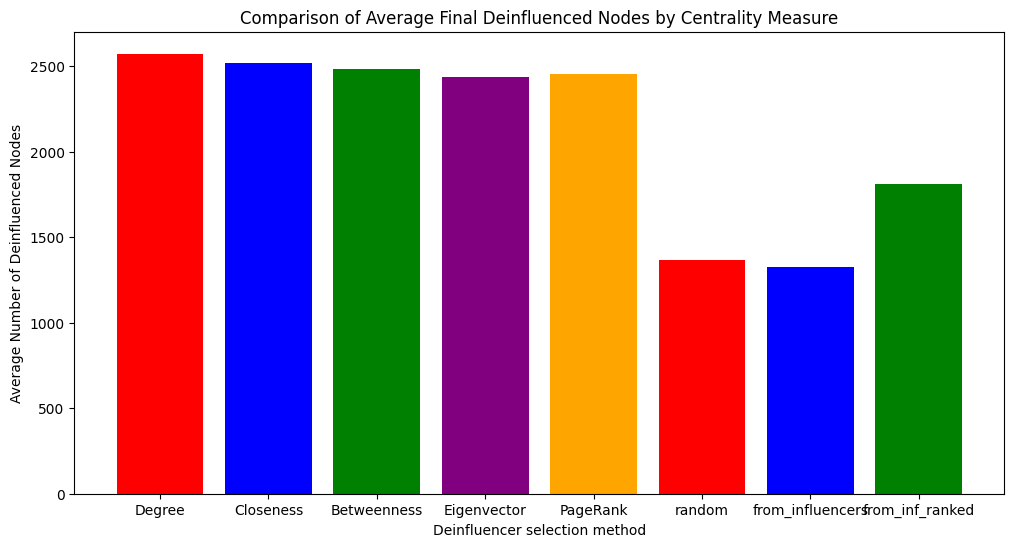

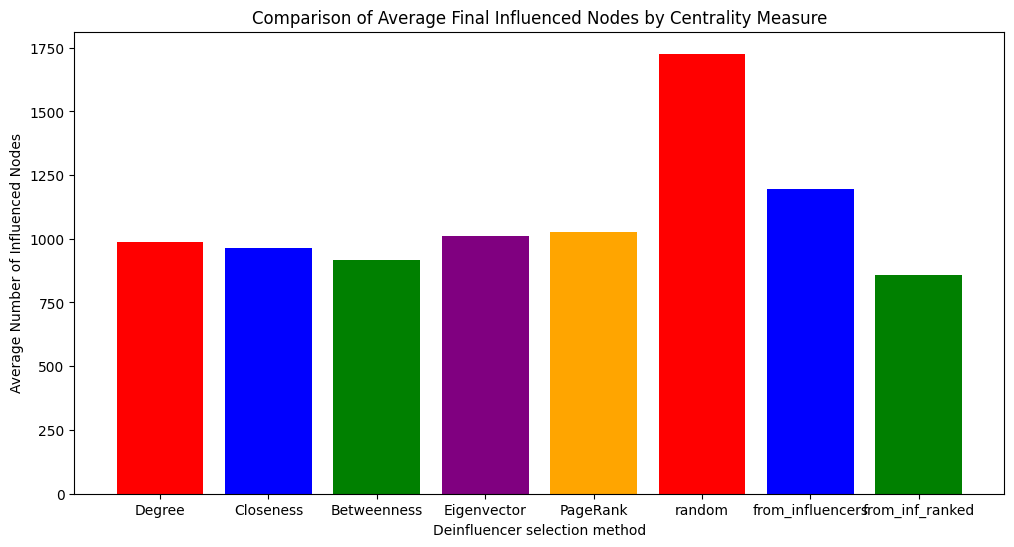

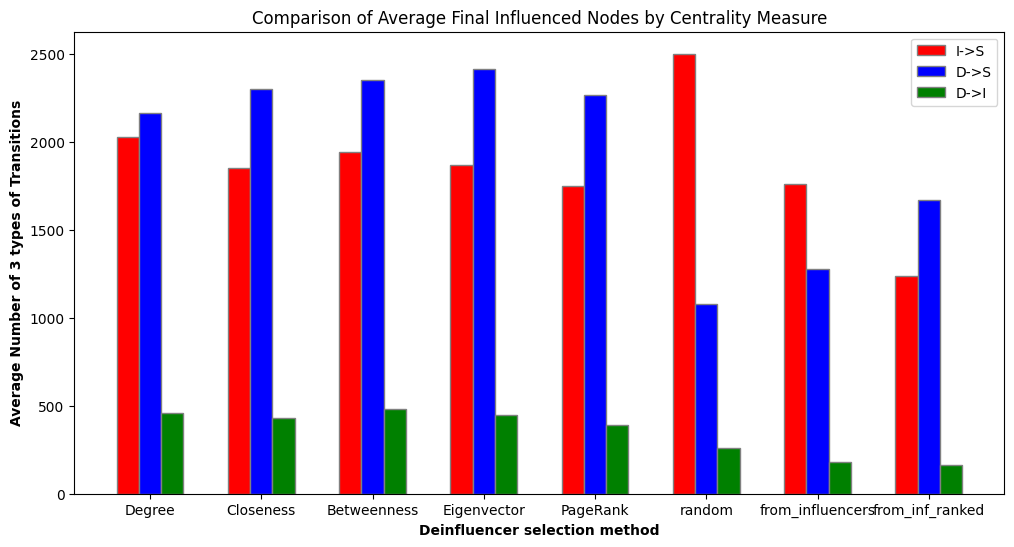

In [8]:
# Initialize the model
model.reset_graph()

# Rank nodes using different centrality measures
k_deinfluencers = 20

# Run cascades and count deinfluenced nodes for each centrality measure
num_runs = 5  # Number of times to run the cascade for averaging
steps = 4  # Number of steps to run the cascade

degree_centrality_ranking = model.select_deinfluencers_degree_centrality(k_deinfluencers)
closeness_centrality_ranking = model.select_deinfluencers_closeness_centrality(k_deinfluencers)
betweenness_centrality_ranking = model.select_deinfluencers_betweenness_centrality(k_deinfluencers)
eigenvector_centrality_ranking = model.select_deinfluencers_eigenvector_centrality(k_deinfluencers, max_iter=1000, tol=1e-06)
pagerank_centrality_ranking = model.select_deinfluencers_pagerank_centrality(k_deinfluencers)
random_deinfluencers = model.select_deinfluencers_random(k_deinfluencers)
#optimized_deinfluencers = model.greedy_hill_climbing_deinf(k_deinfluencers, 5, 10)
deinfleucers_from_influencers = model.select_deinfluencers_from_influencers(j=k_deinfluencers)
ranked_deinfleucers_from_influencers = model.select_deinfluencers_from_influencers_degree_centrality(k_deinfluencers)


print("Degree Centrality Ranking:", degree_centrality_ranking)
print("Closeness Centrality Ranking:", closeness_centrality_ranking)
print("Betweenness Centrality Ranking:", betweenness_centrality_ranking)
print("Eigenvector Centrality Ranking:", eigenvector_centrality_ranking)
print("PageRank Centrality Ranking:", pagerank_centrality_ranking)
print("Random Deinfluencers:", random_deinfluencers)
#print("Optimized Deinfluencers:", optimized_deinfluencers)
print("Deinfluencers from Influencers:", deinfleucers_from_influencers)
print("Ranked Deinfluencers from Influencers:", ranked_deinfleucers_from_influencers)


results_d = {
    'Degree': count_deinfluenced(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_deinfluenced(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_deinfluenced(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_deinfluenced(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_deinfluenced(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_deinfluenced(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    #'hill_climbing': count_deinfluenced(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_deinfluenced(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_deinfluenced(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}

results_i = { 
    'Degree': count_influenced(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_influenced(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_influenced(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_influenced(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_influenced(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_influenced(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    #'hill_climbing': count_influenced(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_influenced(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_influenced(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}

results_w = {
    'Degree': count_transistion(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_transistion(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_transistion(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_transistion(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_transistion(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_transistion(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    #'hill_climbing': count_transistion(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_transistion(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_transistion(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}



# Print the results
#for centrality, count in results.items():
    #print(f"{centrality}: {count:.2f} nodes deinfluenced on average")

# Plot the results
plt.figure(figsize=(12, 6))  # Increase the figure size
plt.bar(results_d.keys(), results_d.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Deinfluencer selection method')
plt.ylabel('Average Number of Deinfluenced Nodes')
plt.title('Comparison of Average Final Deinfluenced Nodes by Centrality Measure')
plt.show()


plt.figure(figsize=(12, 6))  # Increase the figure size
plt.bar(results_i.keys(), results_i.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Deinfluencer selection method')
plt.ylabel('Average Number of Influenced Nodes')
plt.title('Comparison of Average Final Influenced Nodes by Centrality Measure')
plt.show()

# Unpack the values
values1 = [val[0] for val in results_w.values()]
values2 = [val[1] for val in results_w.values()]
values3 = [val[2] for val in results_w.values()]

# Create a new figure
plt.figure(figsize=(12, 6))  # Increase the figure size

# Define the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(values1))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bars
plt.bar(r1, values1, color='red', width=bar_width, edgecolor='grey', label='I->S')
plt.bar(r2, values2, color='blue', width=bar_width, edgecolor='grey', label='D->S')
plt.bar(r3, values3, color='green', width=bar_width, edgecolor='grey', label='D->I')

# Add labels
plt.xlabel('Deinfluencer selection method', fontweight='bold')
plt.ylabel('Average Number of 3 types of Transitions', fontweight='bold')
plt.title('Comparison of Average Final Influenced Nodes by Centrality Measure')

# Add the xticks
plt.xticks([r + bar_width for r in range(len(values1))], results_w.keys())

# Create legend
plt.legend()

# Show the plot
plt.show()